In [1]:
import sys
path = '<git_path>/speedsim'
if path not in sys.path:
    sys.path.append(path)


# MTL Hardware description

### MTL Composed of:
#####    - 2 Atoms quad
#####    - 2 Big cores
#####    - 1 GT
#####    - LLC & DDR memories
#####    - They are connected to Bus (1 port for quad)

In [2]:
# Platform modules
from asap.system_platform import Platform
from asap.hw import Clock, GlobalClock
from asap.ips import IP, Driver, ExecutingUnit, Port
from asap.buses import Bus
from asap.memories import Memory
from asap.strings import PENALTY

Validating System platform: MTL...
System platform is valid!


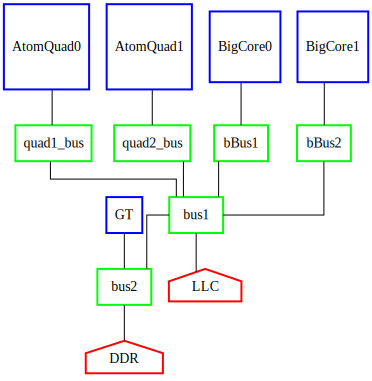

In [3]:

PENALTY_VAL = 1.13333

# Platform
sys_platform = Platform("MTL")

# Clocks
clk = GlobalClock("global_clk", 0.01).instance
a_clk = Clock("a_clk", 0.01)    # 10 ns
b_clk = Clock("b_clk", 0.01)    # 10 ns
g_clk = Clock("g_clk", 0.01)    # 10 ns
sys_platform.add_clock(clk)

# IPs:
# - Ports
# - Drivers
# - Executing units

# Atoms
atoms = dict()
for atom_name in ["AtomQuad{}".format(i) for i in range(2)]:
    p = Port(atom_name + "_p")
    dr = Driver("driver", a_clk)
    ex_units = list()
    for ex in ["ex_u{}".format(j) for j in range(4)]:
        ex_units.append(ExecutingUnit(ex, a_clk))

    atom = IP(atom_name, a_clk, ex_units, [dr], [p])
    atom.connect_driver(dr, p)
    atom.attach_attribute(PENALTY, PENALTY_VAL)
    sys_platform.add_ip(atom)
    atoms[atom_name] = (atom, p)
    
# Big cores
bCores = dict()
for i in range(2):
    bCoreP = Port("BigCore{}_p".format(i))
    dr = Driver("driver", b_clk)
    ex_u = ExecutingUnit("ex_u", b_clk, 1)

    bCore = IP("BigCore{}".format(i), b_clk, [ex_u], [dr], [bCoreP])
    bCore.connect_driver(dr, bCoreP)
    bCore.attach_attribute(PENALTY, 1)
    sys_platform.add_ip(bCore)
    bCores[bCore.name] = (bCore, bCoreP)

# GT 
gt_p = Port('p')
gt_dr = Driver('dr', g_clk)
gt_ex = ExecutingUnit('ex_u', g_clk)

gt = IP("GT", g_clk, [gt_ex], [gt_dr], [gt_p])
gt.connect_driver(gt_dr, gt_p)
sys_platform.add_ip(gt)

# IP Buses
quad1_bus = Bus('quad1_bus', clk, 64)
quad2_bus = Bus('quad2_bus', clk, 64)
bBus1 = Bus('bBus1', clk, 64)
bBus2 = Bus('bBus2', clk, 64)
sys_platform.add_bus(quad1_bus)
sys_platform.add_bus(quad2_bus)
sys_platform.add_bus(bBus1)
sys_platform.add_bus(bBus2)

# System buses
bus1 = Bus('bus1', clk, 64)
bus2 = Bus('bus2', clk, 64)
sys_platform.add_bus(bus1)
sys_platform.add_bus(bus2)

# Memories
llc = Memory('LLC', clk, 1024)
ddr = Memory('DDR', clk, 1024)
sys_platform.add_memory(llc)
sys_platform.add_memory(ddr)

# Connecting
sys_platform.connect_to_bus(atoms["AtomQuad0"][1], quad1_bus)
sys_platform.connect_to_bus(atoms["AtomQuad1"][1], quad2_bus)

sys_platform.connect_to_bus(bCores["BigCore0"][1], bBus1)
sys_platform.connect_to_bus(bCores["BigCore1"][1], bBus2)

sys_platform.connect_to_bus(bBus1, bus1)
sys_platform.connect_to_bus(bBus2, bus1)
sys_platform.connect_to_bus(quad1_bus, bus1)
sys_platform.connect_to_bus(quad2_bus, bus1)
sys_platform.connect_to_bus(bus1, bus2)

sys_platform.connect_to_memory(bus1, llc)
sys_platform.connect_to_memory(bus2, ddr)
sys_platform.connect_to_bus(gt_p, bus2)

sys_platform.validate_platform()
sys_platform

In [4]:
from pnets.plotting import interval_graph
from bokeh.plotting import figure, show, output_notebook
output_notebook()


Loading BokehJS ...

# VPB

### Loading VPB into SpeedSim directly

In [5]:
from pnets.simulation import Simulator
from pnets.pn_model import PnmlModel
fd = open('<pnml_path>', 'r')
vpb_pnml_model = PnmlModel.read(fd)

hw_resources = {'CPU': 4, 'GT_GFX': 1}
sim = Simulator(vpb_pnml_model, hw_resources)
res = sim.run(5000000)


#### VPB reference results

In [6]:

clear_results = res[res['RESOURCE'] != 'NULL']
ys = ['CPU{}'.format(i) for i in range(4)] + ['GT/ex_u']
fig = figure(plot_width=1000, plot_height=800, tools=['xpan', 'xwheel_zoom'], active_scroll='xwheel_zoom', y_range=ys, tooltips=[('name', '@NAME')])

interval_graph(fig, clear_results)
show(fig)

# Atom first scheduler
#### Preferes to map task of map type "Core" to atoms first, if no atom is available then map to big cores

In [7]:
from asap.schedulers import BaseSystemScheduler
from asap.mapping import MappingEntity
from asap.strings import SchedulingState
from collections import namedtuple

class AtomFirstScheduler:
    """
    Atom first scheduler:
        prefer tasks that should be mapped to resource of type core to atoms first with penalty, if all atoms are busy then map to CPU
    """
    def __init__(self, system_mgr):
        self._system_mgr = system_mgr
        self._base_scheduler = BaseSystemScheduler(self._system_mgr)
        self._atoms = self._get_ips(['AtomQuad0', 'AtomQuad1'])
        self._bCores = self._get_ips(['BigCore0', 'BigCore1'])
        self._gt = self._get_ips(['GT'])[0]
        
    def _get_ips(self, names):
        ips = list()
        for ip in self._system_mgr.sys_platform.ips:
            if ip.name in names:
                ips.append(ip)
        return ips
    
    def schedule_task(self, task):
        task_map_type = task.get_attribute('MAP_TYPE', None)
        if task_map_type is None:
            return self._base_scheduler.schedule_task(task, list())
        elif task_map_type == 'GT':
            return self._base_scheduler.schedule_task(task, [MappingEntity(task, self._gt)])
        elif task_map_type == 'Core':
            r, t = self._base_scheduler.schedule_task(task, [MappingEntity(task, a) for a in self._atoms])
            if r is not None or t != SchedulingState.NAN:
                return r, t
            return self._base_scheduler.schedule_task(task, [MappingEntity(task, b) for b in self._bCores])
        else:
            return self._base_scheduler.schedule_task(task, list())
    
    def on_task_finish(self, task):
        self._base_scheduler.on_task_finish(task)


In [19]:
from pnets.pn_model import PnmlModel
fd = open('<pnml_path>', 'r')
vpb_pnml_model = PnmlModel.read(fd)

from asap.strings import TaskMetaData
from asap.utils import from_pnml_model
from speedsim import SpeedSim



hw_resources = {'CPU': {'resource': atoms['AtomQuad1'][0], 'attributes': {'MAP_TYPE': 'Core'}}, 'GT_GFX': {'resource': gt, 'attributes': {'MAP_TYPE': 'GT'}}}
workload, mapping = from_pnml_model(vpb_pnml_model, 'workload', 1, hw_resources)
# for s in workload.get_start_tasks():
#     s.set_property(TaskMetaData.ITERATIONS, 10)

a_clk.period = 0.0005 # 
b_clk.period = 0.00025
g_clk.period = 0.001 # 

sys_platform.reset()
speedsim = SpeedSim(sys_platform, workload, mapping, system_scheduler=AtomFirstScheduler)
res = speedsim.simulate(1000000)


### Atoms first results

In [9]:
clear_results = res[res['RESOURCE'] != 'NULL']
ys = ['AtomQuad0/ex_u{}'.format(i) for i in range(4)] + ['AtomQuad1/ex_u{}'.format(i) for i in range(4)] + ['BigCore0__ex_u', 'BigCore1__ex_u'] + ['GT/ex_u']
fig = figure(plot_width=1000, plot_height=800, tools=['xpan', 'xwheel_zoom'], active_scroll='xwheel_zoom', y_range=ys, tooltips=[('name', '@NAME')])

interval_graph(fig, clear_results)
show(fig)

# Fabric extension
#### Sensitive of the buses current bw
#### Everytime task scheduler or finished to run, it samples the system and update tasks runtime accordingly

In [11]:
from pnets.simulation import EVENTS
from asap.strings import TASK, MappingDesc, TYPE, RESOURCE
from asap.hw import ComponentState
from asap.workload import TYPES
from collections import namedtuple
from pandas import DataFrame

IPBWEvent = namedtuple('BWEvent', ('TIME', 'RESOURCE', 'BW', 'TARGET'))
BUSBWEvent = namedtuple('BWEvent', ('TIME', 'BUS', 'BW'))
IPResidency = namedtuple('IPResidency', ('START', 'FINISH', 'DURATION', 'RESOURCE'))
STARTED = "STARTED"

class FabricExtension:
    BW = "BW"
    
    
    def __init__(self, sim, system_mgr):
        self._sim = sim
        self._system_mgr = system_mgr
        self._sim.connect_to_event(EVENTS.TASK_EXECUTE, self._on_task_execute)
        self._sim.connect_to_event(EVENTS.TASK_END, self._on_task_finish)
        self._ip_bw_events = list()
        self._bus_bw_events = list()
        self._ip_states = list()

    def _on_task_execute(self, transition, resource):
        task = transition.get_pnml_attribute(TASK)

        if task is None:
            return

        if resource is None or resource.resource_type == 'NULL':
            return

        hw_resource = resource.get_attribute(RESOURCE)
        if hw_resource is None:
            return

        ip_start_time = hw_resource.ip.get_attribute(STARTED)
        if ip_start_time is None:
            hw_resource.ip.attach_attribute(STARTED, self._sim.now)
        
        if task.type == TYPES.PROC:
            return

        min_bw = self._get_min_bw(hw_resource.ip, task.get_attribute(MappingDesc.MEMORY_TARGET))
        self._ip_bw_events.append(IPBWEvent(TIME=self._sim.now, RESOURCE=hw_resource.ip.name, BW=min_bw, TARGET=task.get_attribute(MappingDesc.MEMORY_TARGET)))
        data = task.read_bytes + task.write_bytes
        transition.runtime = data / min_bw
        transition.attach_attribute(self.BW, min_bw)
        self._update_tasks(transition, min_bw)

    def _on_task_finish(self, transition, resource):
        task = transition.get_pnml_attribute(TASK)
        if task is None:
            return

        if resource is None or resource.resource_type == 'NULL':
            return

        hw_resource = resource.get_attribute(RESOURCE)
        if hw_resource is None:
            return
        
        if hw_resource.ip.state == ComponentState.FREE:
            start_time = hw_resource.ip.get_attribute(STARTED)
            if start_time is None:
                return
            self._ip_states.append(IPResidency(START=start_time, FINISH=self._sim.now, DURATION=self._sim.now-start_time, RESOURCE=hw_resource.ip.name))
            hw_resource.ip.attach_attribute(STARTED, None)
        if task.type == TYPES.PROC:
            return
        
        min_bw = self._get_min_bw(hw_resource.ip, task.get_attribute(MappingDesc.MEMORY_TARGET))
        self._ip_bw_events.append(IPBWEvent(TIME=self._sim.now, RESOURCE=hw_resource.ip.name, BW=min_bw, TARGET=task.get_attribute(MappingDesc.MEMORY_TARGET)))
        self._update_tasks(transition, min_bw)
        
        
    
    def _get_min_bw(self, source, mem_name):
        if mem_name is None:
            target = self._system_mgr.sys_platform.memories[0]
        else:
            target = self._system_mgr.sys_platform.get_memory(mem_name)
        route_path = self._system_mgr.sys_platform.get_routing_path(source, target)
        # Removing initiator and target
        route_path = route_path[1:-1]
        min_bw = None
        for bus_name in route_path:
            bus = self._system_mgr.sys_platform.get_bus(bus_name[0])
            bw = bus.bw
            self._bus_bw_events.append(BUSBWEvent(TIME=self._sim.now, BUS=bus.name, BW=bw))
            if min_bw is None:
                min_bw = bw
            if bw < min_bw:
                min_bw = bw
        return min_bw
    
    def _update_tasks(self, transition, min_bw):
        end_events = []
        read_write_tasks = [t for t in self._sim.get_executing_tasks() if
                            t[0].get_pnml_attribute(TYPE) != TYPES.PROC and t[0].get_pnml_attribute(TYPE) != TYPES.GEN]
        for executed_task in read_write_tasks:
            if executed_task[0] == transition:
                continue
            event = executed_task[0].end_event
            if event is not None and event.name == EVENTS.TASK_END:
                bw = executed_task[0].get_attribute(self.BW, min_bw)
                remaining_time = event.clock - self._sim.now
                diff = ((remaining_time * (bw / min_bw)) - remaining_time)
                event.clock += diff
                executed_task[0].attach_attribute(self.BW, min_bw)
                end_events.append(event)
                t = executed_task[0].get_pnml_attribute(TASK)
                if t is None:
                    continue
                r = executed_task[1].get_attribute(RESOURCE)
                if r is None:
                    continue
                self._ip_bw_events.append(IPBWEvent(TIME=self._sim.now, RESOURCE=r.ip.name, BW=min_bw, TARGET=t.get_attribute(MappingDesc.MEMORY_TARGET)))
                
        # Update events according to new times
        for event in end_events:
            self._sim.update_event(event)
    
    def get_bw_events(self):
        return DataFrame(self._ip_bw_events), DataFrame(self._bus_bw_events)
    
    def get_ip_stats(self):
        return DataFrame(self._ip_states)
    

# Abstart workload

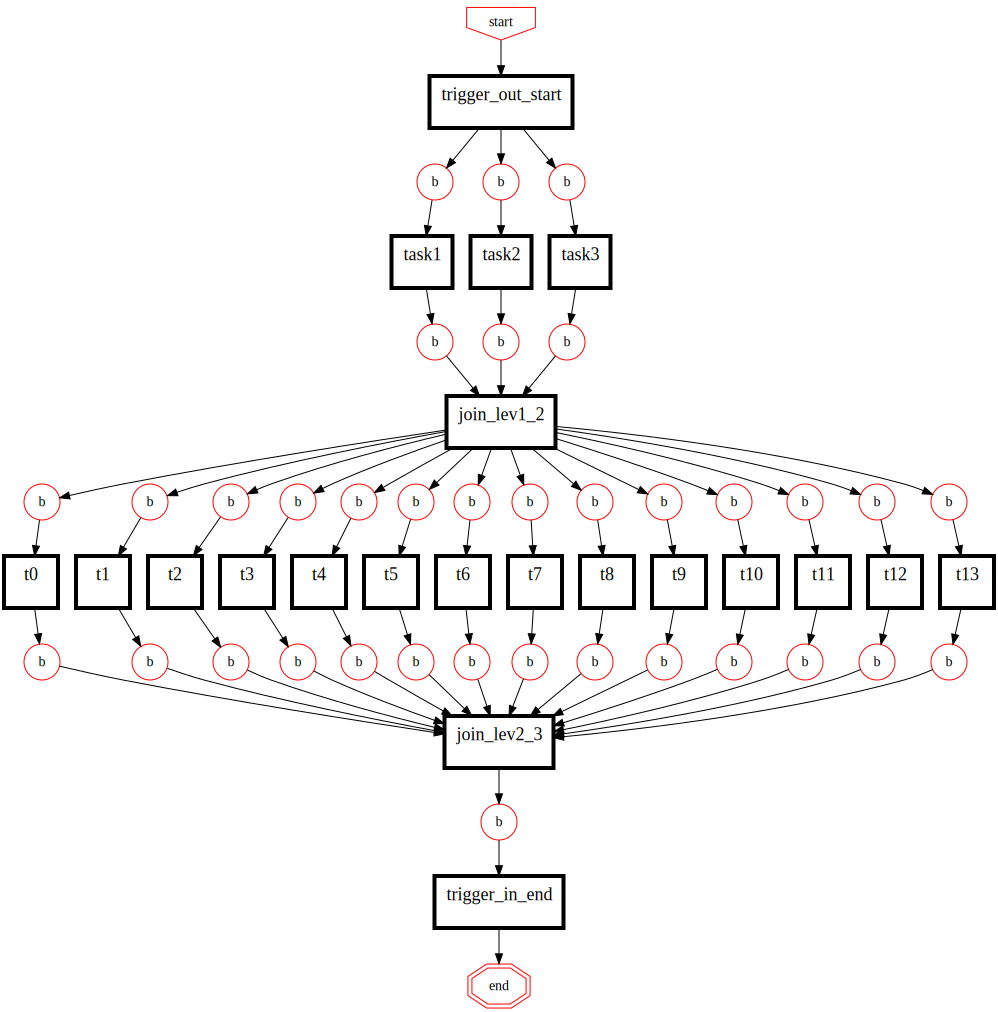

In [13]:
from asap.workload import Workload, Task, Connection
from asap.mapping import Mapping
from asap.strings import MappingDesc

wl = Workload('abstract')
m = Mapping('mapping', wl)

start = Task('start', TYPES.START)
wl.add_task(start)
# Lev1
j1 = Task('join_lev1_2')
wl.add_task(j1)
t = Task('task1', type=TYPES.READ, read_bytes=10240)
t.attach_attribute(MappingDesc.MEMORY_TARGET, 'LLC')
t.attach_attribute('MAP_TYPE', 'Core')
wl.add_task(t)
wl.connect_tasks('1', t, j1)
wl.connect_tasks('2', start, t)
t = Task('task2', type=TYPES.WRITE, write_bytes=20480)
t.attach_attribute(MappingDesc.MEMORY_TARGET, 'LLC')
t.attach_attribute('MAP_TYPE', 'Core')
wl.add_task(t)
wl.connect_tasks('3', t, j1)
wl.connect_tasks('4', start, t)
t = Task('task3', type=TYPES.PROC, processing_cycles=3000)
t.attach_attribute(MappingDesc.MEMORY_TARGET, 'LLC')
t.attach_attribute('MAP_TYPE', 'GT')
wl.add_task(t)
wl.connect_tasks('5', t, j1)
wl.connect_tasks('6', start, t)

j2 = Task('join_lev2_3')
wl.add_task(j2)


# Lev2
for i in range(14):
    t = Task('t{}'.format(i), type=TYPES.PROC, processing_cycles=3540)
    t.attach_attribute('MAP_TYPE', 'Core')
    wl.add_task(t)
    wl.connect_tasks('con{}'.format(i), j1, t)
    wl.connect_tasks('con_{}'.format(i), t, j2)
        
end = Task('end', type=TYPES.END)
wl.add_task(end)
wl.connect_tasks('7', j2, end)


pnml_model = wl.to_pnml_model()
pnml_model

In [14]:
from speedsim import SpeedSim
a_clk.period = 0.0001 # 
b_clk.period = 0.00001
g_clk.period = 0.001 # 

sys_platform.reset()
speedsim = SpeedSim(sys_platform, wl, m, system_scheduler=AtomFirstScheduler, extension=FabricExtension)
res = speedsim.simulate(500000000)
res

,START,FINISH,TRANSITION,RESOURCE,RESOURCE_IDX,DURATION
0,0.000000,0.000000,start/start_trigger,NULL,0,0.000000
1,0.000000,3.000000,task3,GT/ex_u,0,3.000000
2,0.000000,3.200000,task1,AtomQuad0/driver,0,3.200000
3,0.000000,4.800000,task2,AtomQuad1/driver,0,4.800000
4,4.800000,4.800000,join_lev1_2,NULL,0,0.000000
5,4.800000,4.835400,t8,BigCore0/ex_u,0,0.035400
6,4.800000,4.835400,t9,BigCore1/ex_u,0,0.035400
7,4.835400,4.870800,t10,BigCore0/ex_u,0,0.035400
8,4.835400,4.870800,t11,BigCore1/ex_u,0,0.035400
9,4.870800,4.906200,t12,BigCore0/ex_u,0,0.035400


In [15]:
ext = speedsim.get_extension()
ip_bw_events, bus_bw_events = ext.get_bw_events()
ip_bw_events

,TIME,RESOURCE,BW,TARGET
0,0.0,AtomQuad0,6400.0,LLC
1,0.0,AtomQuad1,3200.0,LLC
2,0.0,AtomQuad0,3200.0,LLC
3,3.2,AtomQuad0,6400.0,LLC
4,3.2,AtomQuad1,6400.0,LLC
5,4.8,AtomQuad1,6400.0,LLC


In [16]:
bus_bw_events

,TIME,BUS,BW
0,0.0,quad1_bus,6400.0
1,0.0,bus1,6400.0
2,0.0,quad2_bus,6400.0
3,0.0,bus1,3200.0
4,3.2,quad1_bus,6400.0
5,3.2,bus1,6400.0
6,4.8,quad2_bus,6400.0
7,4.8,bus1,6400.0


In [17]:
ip_res = ext.get_ip_stats()
ip_res

,START,FINISH,DURATION,RESOURCE
0,0.0000,3.000000,3.000000,GT
1,0.0000,3.200000,3.200000,AtomQuad0
2,0.0000,4.800000,4.800000,AtomQuad1
3,4.8000,4.835400,0.035400,BigCore0
4,4.8000,4.835400,0.035400,BigCore1
5,4.8354,4.870800,0.035400,BigCore0
6,4.8354,4.870800,0.035400,BigCore1
7,4.8708,4.906200,0.035400,BigCore0
8,4.8708,4.906200,0.035400,BigCore1
9,4.8000,5.201199,0.401199,AtomQuad0


In [18]:
clear_results = res[res['RESOURCE'] != 'NULL']
ys = ['AtomQuad0/ex_u{}'.format(i) for i in range(4)] + ['AtomQuad1/ex_u{}'.format(i) for i in range(4)] + ['BigCore0__ex_u', 'BigCore1__ex_u'] + ['GT/ex_u']
fig = figure(plot_width=1000, plot_height=800, tools=['xpan', 'xwheel_zoom'], active_scroll='xwheel_zoom', y_range=ys, tooltips=[('name', '@NAME')])

interval_graph(fig, clear_results)
show(fig)